In [1]:
 
import pandas as pd 
import numpy as np 
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import matplotlib.pyplot as plt


import torch 
from torch_geometric.utils.negative_sampling import structured_negative_sampling


from model import LightGCN

 
def create_interaction_edges(userids, movieids, ratings_, threshold=3.5):
    ''' Interaction edges in COO format.'''
    mask = ratings_ > threshold
    edges = np.stack([userids[mask], movieids[mask]])
    return torch.LongTensor(edges)

 
def create_adj_matrix(int_edges, num_users, num_movies):

    n = num_users + num_movies
    adj = torch.zeros(n,n)

    r_mat = torch.sparse_coo_tensor(int_edges, torch.ones(int_edges.shape[1]), size=(num_users, num_movies)).to_dense()
    adj[:num_users, num_users:] = r_mat.clone()
    adj[num_users:, :num_users] = r_mat.T.clone()

    adj_coo = adj.to_sparse_coo()
    adj_coo = adj_coo.indices()

    return adj_coo
 
def adj_to_r_mat(adj, num_users, num_movies):
    n = num_users + num_movies
    adj_dense = torch.sparse_coo_tensor(adj, torch.ones(adj.shape[1]), size=(n, n)).to_dense()
    r_mat = adj_dense[:num_users, num_users:]
    r_coo = r_mat.to_sparse_coo()
    return r_coo.indices()

def adj_to_r_mat_v2(adj, num_users, num_movies):
    n = num_users + num_movies
    adj_dense = torch.sparse_coo_tensor(adj, torch.ones(adj.shape[1]), size=(n, n)).to_dense()
    r_mat = adj_dense[:num_users, num_users:]
    r_coo = r_mat.to_sparse_coo()
    return r_mat

def r2r_mat(r, num_users, num_movies):
    r_mat = torch.zeros(num_users, num_movies)
    r_mat[r[0], r[1]] = 1
    return r_mat
 
## edges = (i, j, k) (i, j) positive edge (i, k) negative edge
def sample_mini_batch(edge_index, batch_size):

    '''
    Args:
        edge_index: edge_index of the user-item interaction matrix
    
    Return:
        structured_negative_sampling return (i,j,k) where
            (i,j) positive edge
            (i,k) negative edge
    '''
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    random_idx = random.choices(list(range(edges[0].shape[0])), k=batch_size)
    batch = edges[:, random_idx]
    user_ids, pos_items, neg_items = batch[0], batch[1], batch[2]
    return user_ids, pos_items, neg_items


def bpr_loss(user_emb, user_emb_0, item_emb, item_emb_0, edge_index_r, batch_size = 128, lambda_= 1e-6):

    user_ids, pos_items, neg_items = sample_mini_batch(edge_index_r, batch_size=batch_size)

    user_emb_sub = user_emb[user_ids]
    pos_item_emb = item_emb[pos_items]
    neg_item_emb = item_emb[neg_items]

    pos_scores = torch.diag(user_emb_sub @ pos_item_emb.T)
    neg_scores = torch.diag(user_emb_sub @ neg_item_emb.T)


    reg_loss = lambda_*(
        user_emb_0[user_ids].norm(2).pow(2) +
        item_emb_0[pos_items].norm(2).pow(2) +
        item_emb_0[neg_items].norm(2).pow(2) # L2 loss
    )

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss
    return loss


def NDCG_K(model, train_r, test_r, K=20):

    # Calculate the ratings for each user-item pair
    userEmbeddings = model.userEmb.weight
    itemEmbeddings = model.itemEmb.weight 
    ratings = userEmbeddings @ itemEmbeddings.T 

    # Set the ratings that are inside the training set to very negative number to ignore them
    ratings[train_r[0], train_r[1]] = -1e12 

    # For each user get the item ids(indices) that user positively interacted
    interaction_mat_test = r2r_mat(test_r, num_users, num_movies) # shape: (num_users, num_items)
    pos_items_each_user_test = [row.nonzero().squeeze(1) for row in interaction_mat_test] 

    # Get top K recommended items (not their ratings but item ids) by the model, ratings are sorted in descending order
    _, topk_items_idxs_pred = torch.topk(ratings, k=K)

    # Turn those recommendation ids into binary, by preserving their recommended positions.
    rec_pred_binary = torch.zeros_like(topk_items_idxs_pred)

    for i in range(topk_items_idxs_pred.shape[0]):
        for j in range(topk_items_idxs_pred.shape[1]):
            if topk_items_idxs_pred[i,j] in pos_items_each_user_test[i]:
                # if the recommended item is in the list that user is positively interacted
                # meaning the recommendation is good
                rec_pred_binary[i,j] = 1

    # Turn positive items for each user into binary 2D array. 
    rec_gt_binary = torch.zeros_like(rec_pred_binary)
    for i in range(rec_gt_binary.shape[0]):
        l = min(len(pos_items_each_user_test[i]), K)
        rec_gt_binary[i, :l] = 1

    # Now calculate the NDGC
    idcg = (rec_gt_binary / torch.log2(torch.arange(K).float() + 2)).sum(dim=1)
    dcg = (rec_pred_binary / torch.log2(torch.arange(K).float() + 2)).sum(dim=1)

    ndcgs = dcg / idcg
    ndcg = ndcgs[~torch.isnan(ndcgs)]

    return ndcg.mean()

ratings = pd.read_csv('ml-latest-small/ratings.csv')
 
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

ratings['userId']  = user_encoder.fit_transform(ratings['userId'])
ratings['movieId'] = movie_encoder.fit_transform(ratings['movieId'])

num_users  = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()


int_edges = create_interaction_edges(ratings['userId'], ratings['movieId'], ratings['rating'])
 
indices = torch.arange(0, int_edges.shape[1], dtype=torch.long)

train_idx, test_idx = train_test_split(indices, test_size=0.2)


train_edges = int_edges[:, train_idx]
test_edges  = int_edges[:, test_idx]
 
train_adj = create_adj_matrix(train_edges, num_users, num_movies)
test_adj  = create_adj_matrix(test_edges, num_users, num_movies)

train_r = adj_to_r_mat(train_adj, num_users, num_movies)
test_r  = adj_to_r_mat(test_adj, num_users, num_movies)

/opt/homebrew/Caskroom/miniforge/base/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 10000/10000 [09:24<00:00, 17.70it/s, Train Loss=-1.23e+3, Val Loss=-1.1e+3, NDCG_K=tensor(0.1103)]


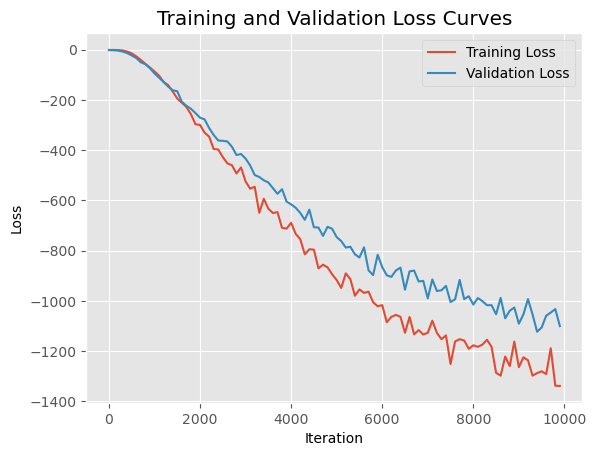

In [2]:
''' ------------ Training Loop ------------ '''

NUM_ITER   = 10000
BATCH_SIZE = 512

model = LightGCN(num_users, num_movies)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

loss_lst = []
val_loss_lst = []
ndcg_k_lst = []

iterator = tqdm(range(NUM_ITER))
val_loss = 0
ndcg_k = 0
for i in iterator:

    model.train()
    optimizer.zero_grad()

    user_emb, user_emb_0, item_emb, item_emb_0 = model(train_adj)
    loss = bpr_loss(
        user_emb, 
        user_emb_0, 
        item_emb, 
        item_emb_0, 
        train_r,
        BATCH_SIZE
        )

    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            user_emb, user_emb_0, item_emb, item_emb_0 = model(test_adj)
        loss_val = bpr_loss(
            user_emb, 
            user_emb_0, 
            item_emb, 
            item_emb_0, 
            test_r,
            BATCH_SIZE
            )
        val_loss = loss_val.item()
        val_loss_lst.append(val_loss)

        ndcg_k = NDCG_K(model, train_r, test_r, K=20)
        ndcg_k_lst.append(ndcg_k)


    iterator.set_postfix({
        'Train Loss': loss.item(),
        'Val Loss': val_loss,
        'NDCG_K': ndcg_k
        })
    loss_lst.append(loss.item())
    
    if i % 200 == 0 and i != 0:
        scheduler.step()


torch.save(model.state_dict(), 'trained_model2.pth')

plt.style.use("ggplot")


x_axis = [i * 100 for i in range(len(val_loss_lst))]
plt.plot(x_axis, np.array(loss_lst)[x_axis], label='Training Loss')
plt.plot(x_axis, val_loss_lst, label='Validation Loss')
plt.title("Training and Validation Loss Curves")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
fig = plt.gcf()
fig.savefig("loss_plot.png", dpi=300)
plt.show()


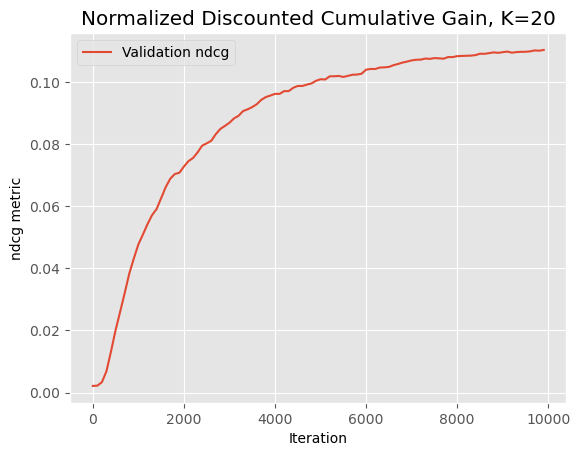

In [10]:
x_axis = [i * 100 for i in range(len(val_loss_lst))]
plt.plot(x_axis, ndcg_k_lst, label='Validation ndcg')
plt.title(f"Normalized Discounted Cumulative Gain, K={20}")
plt.xlabel("Iteration")
plt.ylabel("ndcg metric")
plt.legend()
fig = plt.gcf()
fig.savefig("ndcg.png", dpi=300)
plt.show()

In [3]:
model = LightGCN(num_users, num_movies)
model.load_state_dict(torch.load('trained_model.pth'))

<All keys matched successfully>

In [4]:
def NDCG_K(model, train_r, test_r, K=20):

    # Calculate the ratings for each user-item pair
    userEmbeddings = model.userEmb.weight
    itemEmbeddings = model.itemEmb.weight 
    ratings = userEmbeddings @ itemEmbeddings.T 

    # Set the ratings that are inside the training set to very negative number to ignore them
    ratings[train_r[0], train_r[1]] = -1e12 

    # For each user get the item ids(indices) that user positively interacted
    interaction_mat_test = r2r_mat(test_r, num_users, num_movies) # shape: (num_users, num_items)
    pos_items_each_user_test = [row.nonzero().squeeze(1) for row in interaction_mat_test] 

    # Get top K recommended items (not their ratings but item ids) by the model, ratings are sorted in descending order
    _, topk_items_idxs_pred = torch.topk(ratings, k=K)

    # Turn those recommendation ids into binary, by preserving their recommended positions.
    rec_pred_binary = torch.zeros_like(topk_items_idxs_pred)

    for i in range(topk_items_idxs_pred.shape[0]):
        for j in range(topk_items_idxs_pred.shape[1]):
            if topk_items_idxs_pred[i,j] in pos_items_each_user_test[i]:
                # if the recommended item is in the list that user is positively interacted
                # meaning the recommendation is good
                rec_pred_binary[i,j] = 1

    # Turn positive items for each user into binary 2D array. 
    rec_gt_binary = torch.zeros_like(rec_pred_binary)
    for i in range(rec_gt_binary.shape[0]):
        l = min(len(pos_items_each_user_test[i]), K)
        rec_gt_binary[i, :l] = 1

    # Now calculate the NDGC
    idcg = (rec_gt_binary / torch.log2(torch.arange(K).float() + 2)).sum(dim=1)
    dcg = (rec_pred_binary / torch.log2(torch.arange(K).float() + 2)).sum(dim=1)

    ndcgs = dcg / idcg
    ndcg = ndcgs[~torch.isnan(ndcgs)]

    return ndcg.mean().item()


In [5]:
NDCG_K(model, train_r, test_r, K=20)

0.08938168734312057

In [6]:
K=20
# Calculate the ratings for each user-item pair
userEmbeddings = model.userEmb.weight
itemEmbeddings = model.itemEmb.weight 
ratings = userEmbeddings @ itemEmbeddings.T 

# Set the ratings that are inside the training set to very negative number to ignore them
ratings[train_r[0], train_r[1]] = -1e12 

# For each user get the item ids(indices) that user positively interacted
interaction_mat_test = adj_to_r_mat_v2(test_adj, num_users, num_movies) # shape: (num_users, num_items)
pos_items_each_user_test = [row.nonzero().squeeze(1) for row in interaction_mat_test] 

# Get top K recommended items (not their ratings but item ids) by the model, ratings are sorted in descending order
_, topk_items_idxs_pred = torch.topk(ratings, k=K)

# Turn those recommendation ids into binary, by preserving their recommended positions.
rec_pred_binary = torch.zeros_like(topk_items_idxs_pred)

for i in range(topk_items_idxs_pred.shape[0]):
    for j in range(topk_items_idxs_pred.shape[1]):
        if topk_items_idxs_pred[i,j] in pos_items_each_user_test[i]:
            # if the recommended item is in the list that user is positively interacted
            # meaning the recommendation is good
            rec_pred_binary[i,j] = 1

# Now calculate the NDGC
rec_gt_binary = torch.zeros_like(rec_pred_binary)
for i in range(rec_gt_binary.shape[0]):
    l = min(len(pos_items_each_user_test[i]), K)
    rec_gt_binary[i, :l] = 1

idcg = (rec_gt_binary / torch.log2(torch.arange(K).float() + 2)).sum(dim=1)
dcg = (rec_pred_binary / torch.log2(torch.arange(K).float() + 2)).sum(dim=1)


ndcgs = dcg / idcg
mask = torch.isnan(ndcgs)
ndcg = ndcgs[~mask]
print(ndcg.mean())

tensor(0.0894)
